In [1]:
import os
import re
import time

import h5py
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from nltk import ngrams
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

# Transformers and related libraries
import transformers
from transformers import pipeline, AutoTokenizer, AutoModel

nltk.download('punkt')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load the job ads dataset and ESCO skills ontology
I removed duplicates from the job ads, the dataset is still very big, I won't be using all the entries.
<br>For the ESCO skills ontology, I will only be using the preferred labels and consider all entries as skills, even though ESCO divides them into subcategories.

In [2]:
JOBS_FP = '/kaggle/input/indeed-job-posting-dataset/home/sdf/marketing_sample_for_trulia_com-real_estate__20190901_20191031__30k_data.csv'
ESCO_SKILLS_FP = '/kaggle/input/esco-skills/skills_en.csv'

df = pd.read_csv(JOBS_FP)
print("N before: ", len(df))
df.drop_duplicates(subset=['Job Description'], keep='first', inplace=True)
print("N after: ", len(df))

esco_df = pd.read_csv(ESCO_SKILLS_FP)
# Remove "(text)" occurences
esco_df['label_cleaned'] = esco_df['preferredLabel'].apply(lambda x: re.sub(r'\([^)]*\)', '', x).strip())
# Count words in skills after cleaning
esco_df['word_cnt'] = esco_df['label_cleaned'].apply(lambda x: len(str(x).split()))
esco_df = pd.DataFrame(esco_df, columns=['label_cleaned', 'altLabels', 'word_cnt'])

N before:  30002
N after:  24714


**Skills lengths**<br>
I checked the word count frequency in ESCO skills, most of them consist of 3 words and just by looking you could say almost no skills consist of more than 9 words. I planned to use this for determining the maximal ngram length, but in the end opted for whole sentence representation

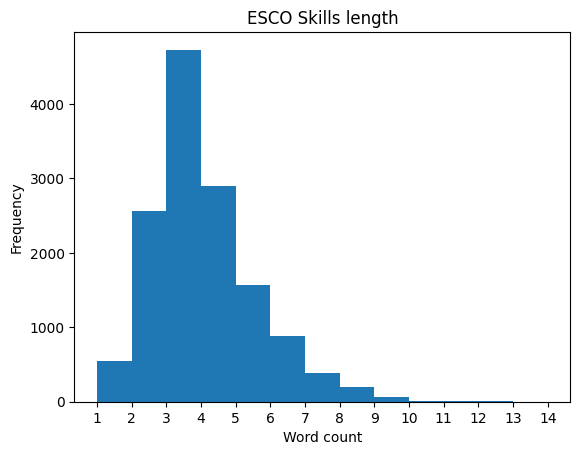

In [3]:
max_value = max(esco_df.word_cnt)
bins = range(1, max_value + 2)

plt.hist(esco_df.word_cnt, bins=bins)
plt.xticks(range(1, max_value + 2))

plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.title('ESCO Skills length')
plt.savefig('esco_word_count.png')
plt.show()

In [4]:
class EscoDataset(Dataset):
    def __init__(self, df, skill_col, backbone):
        texts = df
        self.tokenizer = AutoTokenizer.from_pretrained(backbone)
        self.texts = texts[skill_col].values.tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        res = self.tokenizer(
            self.texts[idx],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=20
        )
        return {k:v[0] for k,v in res.items()}

    
class ClsPool(nn.Module):
    def forward(self, x):
        # batch * num_tokens * num_embedding
        return x[:, 0, :]    

    
class BertModel(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        
        self.backbone_name = backbone
        self.backbone = AutoModel.from_pretrained(backbone)
        self.pool = ClsPool()
    
    def forward(self, x):
        x = self.backbone(**x)["last_hidden_state"]
        x = self.pool(x)
        
        return x

## JobBERT
JobBERT is a BERT model pre-trained on job propositions, it came from a paper where they concluded that a domain-specific pretrained model outperformed the non-adapted versions and published their model on [Huggingface](https://huggingface.co/jjzha/jobbert-base-cased). I will use it to create embeddings of ESCO skills, then embed the job postings and find relevant ESCO skills using vector similarity

In [5]:
backbone = 'jjzha/jobbert-base-cased'
emb_label = 'jobbert'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and Dataloader
ds = EscoDataset(esco_df, 'label_cleaned', backbone)
dl = DataLoader(ds, shuffle=False, batch_size=32)

# Build custom model
model = BertModel(backbone)
model.eval()
model.to(device)

# Get embeddings for each skill
embs = []
with torch.no_grad():
    for i, x in enumerate(dl):
        x = {k:v.to(device) for k, v in x.items()}
        out = model(x)
        embs.extend(out.detach().cpu())
# Add them to the DataFrame
esco_df[emb_label] = embs

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/603 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def get_sentences(job):
    """
    Given a raw html job description, parse it into sentences
    by using nltk's sentence tokenization + new line splitting
    """
    soup = BeautifulSoup(job, 'html.parser')
    # Found some ads using unicode bullet points
    for p in soup.find_all('p'):
        p.string = p.get_text().replace("•", "")
    text = soup.get_text()
    st = sent_tokenize(text)
    sentences = []
    for sent in st:
        sentences.extend([x for x in sent.split('\n') if x !=''])
    return sentences

def compute_similarity(vec, emb_type):
    """
    Compute vector similarity for a given vec and all the ESCO skills embeddings.
    If more embeddings were created, the type is specified by the input parameter.
    Return the ESCO skill id with max similarity
    """
    esco_embs = esco_df[emb_type]
    sims = []
    # Compute cosine similarities
    for i, esco_vec in enumerate(esco_embs):
        sims.append((i, cosine_similarity(vec, esco_vec.reshape(1, -1))))
    # Return max similarity and esco skill index
    idx, sim = max(sims, key=lambda x: x[1])
    return idx, sim.item()


def compute_similarity_opt(emb_vec, emb_type):
    """
    Compute vector similarity for a given vec and all the ESCO skills embeddings
    by constructing a matrix from ESCO embeddings to process it faster.
    Return the ESCO skill id with max similarity
    """
    esco_embs = [x for x in esco_df[emb_type]]
    esco_vectors = torch.stack(esco_embs)
    # Normalize the stacked embeddings and the input vector
    norm_esco_vectors = torch.nn.functional.normalize(esco_vectors, p=2, dim=1)
    norm_emb_vec = torch.nn.functional.normalize(emb_vec.T, p=2, dim=0)
    # Compute cosine similarities
    cos_similarities = torch.matmul(norm_esco_vectors, norm_emb_vec)
    # Return max similarity and esco skill index
    sim, idx = torch.max(cos_similarities, dim=0)
    return idx.item(), sim.item()

def compute_similarity_mat(emb_mat, emb_type):
    esco_embs = [x for x in esco_df[emb_type]]
    esco_vectors = torch.stack(esco_embs)
    emb_vectors = torch.stack(emb_mat)
    # Normalize the stacked embeddings and the input vectors
    norm_esco_vectors = torch.nn.functional.normalize(esco_vectors, p=2, dim=1)
    norm_emb_vecs = torch.nn.functional.normalize(emb_vectors.T, p=2, dim=0)
    # Compute cosine similarities
    cos_similarities = torch.matmul(norm_esco_vectors, norm_emb_vecs)
    # Return max similarity and esco skill index
    max_similarities, max_indices = torch.max(cos_similarities, dim=0)
    return max_indices.numpy(), max_similarities.numpy()

In [7]:
def get_embedding(x):
    x = tokenizer(x, return_tensors='pt')
    x = {k:v.to(device) for k, v in x.items()}
    return model(x).detach().cpu()

def process_sentence(sent):
    emb = get_embedding(sent)
    return compute_similarity_opt(emb, emb_label)

tokenizer = AutoTokenizer.from_pretrained(backbone)
model = BertModel(backbone)
model.to(device)
model.eval()

# Used in performance optimization and output example
job_sample = df.iloc[15]['Job Description']
threshold = .8

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Performance optimization
By improving the similarity calculation (using tensor operations) on one random job sample, the processing time for all the sentences went down from around 160 seconds to 2 seconds. (A different sample showed improvement from 300 to 5 seconds. The time improvement value is not exact but the improvement is significant)

In [127]:
sentences = get_sentences(job_sample)

# Simple similarity
sim_start_time = time.time()
for sent in sentences:
    x = tokenizer(sent, return_tensors='pt')
    x = {k:v.to(device) for k, v in x.items()}
    emb = model(x).detach().cpu()
    idx, sim = compute_similarity(emb.numpy(), emb_label)

sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"One-by-one similarity execution time: {execution_time:.4f} seconds")

# Optimized similarity
sim_start_time = time.time()
for sent in sentences:
    x = tokenizer(sent, return_tensors='pt')
    x = {k:v.to(device) for k, v in x.items()}
    emb = model(x).detach().cpu()
    idx, sim = compute_similarity_opt(emb, emb_label)

sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Optimized similarity execution time: {execution_time:.4f} seconds")

One-by-one similarity execution time: 165.6036 seconds
Optimized similarity execution time: 2.0319 seconds


### Further optimization
I edited the method once again to compute the similarity between two matrices (matrix of sentence embeddings and a matrix of esco embeddings) in one operation. This further enhanced the processing time.

In [10]:
sentences = get_sentences(job_sample)

sim_start_time = time.time()
sent_embs = []
for sent in sentences:
    x = tokenizer(sent, return_tensors='pt')
    x = {k:v.to(device) for k, v in x.items()}
    emb = model(x).detach().cpu()
    sent_embs.append(emb.squeeze())
idxs, sims = compute_similarity_mat(sent_embs, emb_label)
# Calculate job description processing time
sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 0.4979 seconds


**Example with ESCO mapping outputs**

I am using a threshold parameter to filter out unlikely matches. We can see that the sentence-wise detection made some mistakes but the mapped skills are not entirely irrelevant. I also display speeds for both "fast" similarity calculation approaches

In [11]:
sim_start_time = time.time()
res = []
sentences = get_sentences(job_sample)
for sent in sentences:
    idx, sim = process_sentence(sent)
    if sim > threshold:
        res.append((sent, esco_df.iloc[idx]['label_cleaned'], sim))

sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Execution time: {execution_time:.4f} seconds")

for r in res:
    print('=========================')
    print(f"sentence: {r[0]}\nESCO skill:{r[1]}\nSimilarity:{r[2]:.4f}") 

Execution time: 3.0104 seconds
sentence: Contribute to & maintain open source projects
ESCO skill:operate open source software
Similarity:0.8464
sentence: Familiar with agile methodologies
ESCO skill:Agile development
Similarity:0.8328
sentence: Experience with design and development of backend services
ESCO skill:implement front-end website design
Similarity:0.8274
sentence: Experience with software testing methodologies
ESCO skill:levels of software testing
Similarity:0.8499
sentence: Contributions to open-source projects
ESCO skill:Open source model
Similarity:0.8590


In [12]:
sim_start_time = time.time()
res = []
sent_embs = []
sentences = get_sentences(job_sample)
for sent in sentences:
    sent_embs.append(get_embedding(sent).squeeze())
    
idxs, sims = compute_similarity_mat(sent_embs, emb_label)
for i in range(len(idxs)):
    if sims[i] > threshold:
        res.append((sentences[i], esco_df.iloc[idxs[i]]['label_cleaned'], sims[i]))

sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Execution time: {execution_time:.4f} seconds")

for r in res:
    print('=========================')
    print(f"sentence: {r[0]}\nESCO skill:{r[1]}\nSimilarity:{r[2]:.4f}")

Execution time: 0.4991 seconds
sentence: Contribute to & maintain open source projects
ESCO skill:operate open source software
Similarity:0.8464
sentence: Familiar with agile methodologies
ESCO skill:Agile development
Similarity:0.8328
sentence: Experience with design and development of backend services
ESCO skill:implement front-end website design
Similarity:0.8274
sentence: Experience with software testing methodologies
ESCO skill:levels of software testing
Similarity:0.8499
sentence: Contributions to open-source projects
ESCO skill:Open source model
Similarity:0.8590


## JobBERT and EscoXLMR
The author of the JobBERT model also created demos on Huggingface using his already-trained models that extract skills based on token classification. The code for the demo is available [here](https://huggingface.co/spaces/jjzha/skill_extraction_demo/tree/main). I modified the code so that the model outputs are checked agains a threshold for skill detection and then the filtered texts are encoded and mapped to ESCO skills using vector similarity with another threshold value.

I tried both JobBERT and EscoXLMR but it seemed to me EscoXMLR had some problems with respresenting found spans correctly, moreover I am already using JobBERT embeddings so I opted for this model.

In [13]:
def get_classifiers(mtype):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if mtype == "jobbert":
        token_skill_classifier = pipeline(model="jjzha/jobbert_skill_extraction", aggregation_strategy="first", device=device)
        token_knowledge_classifier = pipeline(model="jjzha/jobbert_knowledge_extraction", aggregation_strategy="first", device=device)
    elif mtype == "xlmr":        
        token_skill_classifier = pipeline(model="jjzha/escoxlmr_skill_extraction", aggregation_strategy="first", device=device)
        token_knowledge_classifier = pipeline(model="jjzha/escoxlmr_knowledge_extraction", aggregation_strategy="first", device=device)
    else:
        raise Exception("Unknown model name provided")
    return token_skill_classifier, token_knowledge_classifier


def extract_skills(job, token_skill_classifier, token_knowledge_classifier, out_treshold=.8, sim_threshold=.8):
    """
    Function that processes outputs from pre-trained, ready to use models
    that detect skills as a token classification task. There are two thresholds,
    out_threshold for filtering model outputs and sim_threshold for filtering
    based on vector similarity with ESCO skills
    """     
    sentences = get_sentences(job)
    pred_labels = []
    res = []
    skill_embs = []
    skill_texts = []
    for sent in sentences:
        skills = ner(sent, token_skill_classifier, token_knowledge_classifier)
        for entity in skills['entities']:
            text = entity['word']
            if entity['score'] > out_treshold:
                skill_embs.append(get_embedding(text).squeeze())
                skill_texts.append(text)
                
    idxs, sims = compute_similarity_mat(skill_embs, emb_label)
    for i in range(len(idxs)):
        if sims[i] > sim_threshold:
            pred_labels.append(idxs[i])
            res.append((skill_texts[i], esco_df.iloc[idxs[i]]['label_cleaned'], sims[i]))
    return pred_labels, res


def aggregate_span(results):
    new_results = []
    current_result = results[0]

    for result in results[1:]:
        if result["start"] == current_result["end"] + 1:
            current_result["word"] += " " + result["word"]
            current_result["end"] = result["end"]
        else:
            new_results.append(current_result)
            current_result = result

    new_results.append(current_result)

    return new_results


def ner(text, token_skill_classifier, token_knowledge_classifier):
    output_skills = token_skill_classifier(text)
    for result in output_skills:
        if result.get("entity_group"):
            result["entity"] = "Skill"
            del result["entity_group"]

    output_knowledge = token_knowledge_classifier(text)
    for result in output_knowledge:
        if result.get("entity_group"):
            result["entity"] = "Knowledge"
            del result["entity_group"]

    if len(output_skills) > 0:
        output_skills = aggregate_span(output_skills)
    if len(output_knowledge) > 0:
        output_knowledge = aggregate_span(output_knowledge)
    
    skills = []
    skills.extend(output_skills)
    skills.extend(output_knowledge)
    return {"text": text, "entities": skills}

We can see that this approach catches much more skills as it works on token-level. Most of them are also correct

In [14]:
tsc, tkc = get_classifiers("jobbert")

start_time = time.time()
_, res = extract_skills(job_sample, tsc, tkc)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")
for r in res:
    print('=========================')
    print(f"text: {r[0]}\nESCO skill:{r[1]}\nSimilarity:{r[2]:.4f}")

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Execution time: 1.3490 seconds
text: self - direction
ESCO skill:self-promote
Similarity:0.8803
text: building creative solutions to challenging problems
ESCO skill:create solutions to problems
Similarity:0.8554
text: work in a team
ESCO skill:work in a landscape team
Similarity:0.9260
text: Contribute to & maintain open source projects
ESCO skill:operate open source software
Similarity:0.8464
text: open source projects
ESCO skill:Open source model
Similarity:0.9168
text: software engineering
ESCO skill:computer engineering
Similarity:0.8377
text: leading a team
ESCO skill:lead a team
Similarity:0.9468
text: agile methodologies
ESCO skill:Agile development
Similarity:0.8723
text: design and development of backend services
ESCO skill:implement front-end website design
Similarity:0.8291
text: backend
ESCO skill:JavaScript
Similarity:0.8135
text: Java
ESCO skill:Java
Similarity:1.0000
text: Python
ESCO skill:Python
Similarity:1.0000
text: Javascript
ESCO skill:JavaScript
Similarity:0.9068

### Small labelled data subset
My task was to label a subset of data, I found out that the task was harder than I expected so I ended up manually labelling only 4 randomly selected job ads. For the labelling approach, I chose to use index names of ESCO skills as labels. It is true that this might mean that some skills, that are present in the description will not be picked up, but the outputs will be more uniform.

Another approach I though about was to label the data on span-level with the help of a labeling tool to make it faster and easier. I would then use just the parts of text detected as skills instead of ESCO terms. This might have helped to better extract concrete skills rather than generalized ontology terms.

In [15]:
def calculate_metrics(preds, labels):
    tp = 0
    fp = 0
    fn = 0
    for k, v in preds.items():
        target = labels[k] 
        # Calculate TP, FP, FN for the current entry
        tp += sum(1 for i in range(len(v)) if v[i] in target)
        fp += sum(1 for i in range(len(v)) if v[i] not in target)
        fn += sum(1 for i in range(len(target)) if target[i] not in v)

    # Calculate precision, recall, and F1-score for the current entry
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}")

In [16]:
df_sample = df.loc[[5, 211, 434, 6141]]
df_sample['labels'] = [
    [7049, 4850, 5814, 6104, 2180, 8242, 4893, 13032, 3453, 11317, 2966, 13431, 3654, 8186, 6224, 6762],
    [233, 6498, 9743, 4922, 3673],
    [13557, 5734, 7203, 1166, 1121, 8793],
    [1370, 11127, 4544, 3338, 6670, 699, 6667, 521, 680, 6535]
]
df_sample[['Job Description', 'labels']].to_csv("df_sample_labeled.csv")

for index, s in df_sample.iterrows():
    esco_skills = [esco_df.loc[x]['label_cleaned'] for x in s['labels']]
    print(s['Job Title'], '\n', esco_skills, "\n-----------------------------")

Cyber IT Risk & Strategy Senior Consultant 
 ['cyber security', 'cyber attack counter-measures', 'implement ICT risk management', 'risk management', 'perform business analysis', 'apply risk management processes', 'perform church service', 'DevOps', "assess risks of clients' assets", 'present reports', 'develop information security strategy', 'implement strategic planning', 'identify technological needs', 'consult with business clients', 'project management', 'advise client on technical possibilities'] 
-----------------------------
AV Systems Drawings AutoCAD Engineer 
 ['design electrical systems', 'create AutoCAD drawings', 'use CAD software', 'technical drawings', 'mathematics'] 
-----------------------------
Pre-owned Auto Sales Consultant 
 ['advise customers on motor vehicles', "identify customer's needs", 'satisfy customers', 'communication', 'Spanish', 'understand spoken Spanish'] 
-----------------------------
Senior Java Developer 
 ['Java', 'Python', 'Groovy', 'JavaScript', 

In [17]:
threshold = .8
preds = {}
res_log = {}
sim_start_time = time.time()
for index, s in df_sample.iterrows():
    res = []
    pred_labels = []
    sent_embs = []
    sentences = get_sentences(s['Job Description'])
    for sent in sentences:
        sent_embs.append(get_embedding(sent).squeeze())
        
    idxs, sims = compute_similarity_mat(sent_embs, emb_label)
    for i in range(len(idxs)):
        if sims[i] > threshold:
            pred_labels.append(idxs[i])
            res.append((sentences[i], esco_df.iloc[idxs[i]]['label_cleaned'], sims[i]))
    # Save results
    preds[index] = list(set(pred_labels))
    res_log[index] = list(set(res))
# Calculate job description processing time
sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Execution time: {execution_time:.4f} seconds")
calculate_metrics(preds, df_sample['labels'])

Execution time: 1.4995 seconds
Precision: 0.1538, Recall: 0.0541, F1-score: 0.0800


In [18]:
out_treshold = .8
sim_treshold = .8
preds = {}
res_log = {}
start_time = time.time()
for index, s in df_sample.iterrows():
    pred_labels, res = extract_skills(s['Job Description'], tsc, tkc)
    # Save results
    preds[index] = list(set(pred_labels))
    res_log[index] = list(set(res))
# Calculate job description processing time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")
calculate_metrics(preds, df_sample['labels'])

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Execution time: 4.1726 seconds
Precision: 0.3167, Recall: 0.5135, F1-score: 0.3918


## N-grams extraction
I also tried splitting the words to at most 4-words long n-grams and extracted skills this way. I tried multiple combinations, selecting all similarities above a given threshold, then remove duplicates or only taking a maximum value per sentences.

**Only max similarity n-gram for each sentence**

In [43]:
threshold = .85
preds = {}
res_log = {}

sim_start_time = time.time()
for index, s in df_sample.iterrows():
    res = []
    pred_labels = []
    sentences = get_sentences(s['Job Description'])
    
    for sent in sentences:
        ngram_embs = []
        sent_emb = get_embedding(sent).squeeze()

        words = sent.split()
        ngram_max_len = 4 if len(words) > 4 else len(words)
        ngram_list = [gram for i in range(1, ngram_max_len+1) for gram in list(ngrams(words, i))]
        for ngram in ngram_list:
            text = ' '.join(ngram)
            ngram_embs.append(get_embedding(text).squeeze()*0.8 + sent_emb*0.2)
            
        idxs, sims = compute_similarity_mat(ngram_embs, emb_label)
        max_idx = np.argmax(sims)
        if sims[max_idx] > threshold:
            pred_labels.append(idxs[max_idx])
            res.append((ngram_list[max_idx], esco_df.iloc[idxs[max_idx]]['label_cleaned'], sims[max_idx]))
    preds[index] = list(set(pred_labels))
    res_log[index] = list(set(res))
        
# Calculate job description processing time
sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Execution time: {execution_time:.4f} seconds")
calculate_metrics(preds, df_sample['labels'])

Execution time: 65.8697 seconds
Precision: 0.1562, Recall: 0.2703, F1-score: 0.1980


**All similarity n-gram above threshold**

In [48]:
threshold = .85
preds = {}
res_log = {}

sim_start_time = time.time()
for index, s in df_sample.iterrows():
    res = []
    pred_labels = []
    ngram_embs = []
    ngram_texts = []
    sentences = get_sentences(s['Job Description'])
    
    for sent in sentences:
        sent_emb = get_embedding(sent).squeeze()

        words = sent.split()
        ngram_max_len = 4 if len(words) > 4 else len(words)
        ngram_list = [gram for i in range(ngram_min_len, ngram_max_len+1) for gram in list(ngrams(words, i))]
        for ngram in ngram_list:
            text = ' '.join(ngram)
            ngram_embs.append(get_embedding(text).squeeze()*0.8 + sent_emb*0.2)
            ngram_texts.append(text)
            
    idxs, sims = compute_similarity_mat(ngram_embs, emb_label)
    for i in range(len(idxs)):
        if sims[i] > threshold:
            pred_labels.append(idxs[i])
            res.append((ngram_texts[i], esco_df.iloc[idxs[i]]['label_cleaned'], sims[i]))
    preds[index] = list(set(pred_labels))
    res_log[index] = list(set(res))
        
# Calculate job description processing time
sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Execution time: {execution_time:.4f} seconds")
calculate_metrics(preds, df_sample['labels'])

Execution time: 43.0602 seconds
Precision: 0.1136, Recall: 0.4054, F1-score: 0.1775


## Exploring possible job benefits ontology

In [53]:
df_temp = pd.read_csv("/kaggle/input/job-description-dataset/job_descriptions.csv")
df_temp = df_temp.loc[:]['Benefits']

In [54]:
benefits = set()
for row in df_temp:
    words = re.sub(r'[\{\}\']', '', row).split(',')
    for w in words:
        benefits.add(w)

In [60]:
print(len(benefits))
benefits

35


{' Bonuses and Incentive Programs',
 ' Casual Dress Code',
 ' Childcare Assistance',
 ' Employee Assistance Programs (EAP)',
 ' Employee Discounts',
 ' Employee Recognition Programs',
 ' Employee Referral Programs',
 ' Financial Counseling',
 ' Flexible Spending Accounts (FSAs)',
 ' Flexible Work Arrangements',
 ' Health Insurance',
 ' Health and Wellness Facilities',
 ' Legal Assistance',
 ' Life and Disability Insurance',
 ' Paid Time Off (PTO)',
 ' Parental Leave',
 ' Professional Development',
 ' Profit-Sharing',
 ' Relocation Assistance',
 ' Retirement Plans',
 ' Social and Recreational Activities',
 ' Stock Options or Equity Grants',
 ' Transportation Benefits',
 ' Tuition Reimbursement',
 ' Wellness Programs',
 'Casual Dress Code',
 'Childcare Assistance',
 'Employee Assistance Programs (EAP)',
 'Employee Referral Programs',
 'Flexible Spending Accounts (FSAs)',
 'Health Insurance',
 'Legal Assistance',
 'Life and Disability Insurance',
 'Transportation Benefits',
 'Tuition Reim